In [12]:
%config Completer.use_jedi = False
%matplotlib notebook
import astropy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.table import Table
from astropy.io import fits
from glob import glob
import os
from tqdm import tqdm_notebook, tnrange, tqdm
#import pandas as pd
from astropy.wcs import WCS
import sys
from spectral_cube import SpectralCube
import fs
import fs.copy
import socket
import warnings

In [13]:
from RMtools_3D.do_RMsynth_3D import run_rmsynth, writefits as dirtywf, readFitsCube, readFreqFile
from RMtools_3D.do_RMclean_3D import writefits as cleanwf, run_rmclean
from RMutils.util_RM import do_rmclean_hogbom

In [14]:
import pymongo
client = pymongo.MongoClient()  # default connection (ie, local)

In [15]:
mydb = client['racs']  # Create/open database

In [16]:
mycol = mydb['spice']  # Create/open collection

In [17]:
document = mycol.find_one()
for k in document:
    print(k)

_id
header
island_id
island_name
n_components
ra_hms_cont
dec_dms_cont
ra_deg_cont
dec_deg_cont
freq
maj_axis
min_axis
pos_ang
flux_int
flux_int_err
flux_peak
mean_background
background_noise
max_residual
min_residual
mean_residual
rms_residual
stdev_residual
x_min
x_max
y_min
y_max
n_pix
solid_angle
beam_area
x_ave
y_ave
x_cen
y_cen
x_peak
y_peak
flag_i1
flag_i2
flag_i3
flag_i4
comment
i_file
q_file
u_file


In [18]:
# Basic querey
myquery = { "n_components": { "$lt": 2 } }

#mydoc = mycol.find(myquery, { "_id": 0, "island_name": 1, "flux_int": 1 , "n_components": 1})
mydoc = mycol.find(myquery).sort("flux_int", -1)
mydoc.count()
#for x in mydoc:
#    print(x)

3483

In [8]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
import schwimmbad
from multiprocessing import cpu_count

In [20]:
import shlex, subprocess

In [21]:
n_cores = cpu_count() # Use all available cores
use_mpi = False # Use or not with Schwimmbad

outdir = '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts'
try:
    os.mkdir(outdir)
except:
    print('Directory exists')
for i in tnrange(10):
    # Copy I
    command_line = f"cp {mydoc[i]['i_file']} {outdir}/"
    args = shlex.split(command_line)
    subprocess.run(args, capture_output=True)
    # Copy Q
    command_line = f"cp {mydoc[i]['q_file']} {outdir}/"
    args = shlex.split(command_line)
    subprocess.run(args, capture_output=True)
    # Copy U
    command_line = f"cp {mydoc[i]['u_file']} {outdir}/"
    args = shlex.split(command_line)
    subprocess.run(args, capture_output=True)
    
    idata = SpectralCube.read(mydoc[i]["i_file"], mode='denywrite')
    qdata = SpectralCube.read(mydoc[i]["q_file"], mode='denywrite')
    udata = SpectralCube.read(mydoc[i]["u_file"], mode='denywrite')
    
    freqfile = f"{outdir}/frequencies.txt"
    freq = np.loadtxt(freqfile)
    
    dataArr = run_rmsynth(qdata.hdu.data, 
                          udata.hdu.data, 
                          freq, 
                          verbose=False, 
                          nSamples=5
                         )
    preout = f"{mydoc[i]['island_name']}."
    dirtywf(dataArr, 
              idata.header, 
              prefixOut=preout,
              outDir=outdir,
              not_rmsf=False,
              verbose=False
             )
    
    FDFcube, phiArr_radm2, RMSFcube, phi2Arr_radm2, \
        fwhmRMSFCube,fitStatArr, lam0Sq_m2, lambdaSqArr_m2 = dataArr
    with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
        fitsFDF = f"{outdir}/{preout}FDF_dirty.fits"
        fitsRMSF = f"{outdir}/{preout}RMSF.fits"
        cleanFDF, ccArr, iterCountArr, residFDF, head \
                = run_rmclean(fitsFDF,
                            fitsRMSF,
                            1,
                            maxIter=1000,
                            gain=0.1,
                            nBits=32,
                            pool=pool,
                            chunksize=None,
                            verbose=False,
                        )
        
    cleanwf(cleanFDF,
            ccArr,
            iterCountArr,
            residFDF,
            head,
            prefixOut=preout,
            outDir=outdir,
            write_separate_FDF=False,
            verbose=False
           )

Directory exists


In [24]:
from astropy.table import Table

In [37]:
ras = []
decs = []
names = []
cols = ['ra_deg_cont', 'dec_deg_cont', 'island_name']
for i in tnrange(10):
    ras.append(mydoc[i][cols[0]])
    decs.append(mydoc[i][cols[1]])
    names.append(mydoc[i][cols[2]])

In [38]:
t = Table([ras,decs,names], names=cols)

In [42]:
t

ra_deg_cont,dec_deg_cont,island_name
float64,float64,str14
159.316835,-29.567359,J103716-293402
162.769628,-31.637289,J105104-313814
159.348867,-29.131603,J103723-290753
161.419004,-29.457327,J104540-292726
165.278243,-31.674406,J110106-314027
165.278243,-31.674406,J110106-314027
165.578604,-31.045879,J110218-310245
160.730161,-28.82157,J104255-284917
165.500406,-31.231526,J110200-311353


In [43]:
t.write(f'{outdir}/spice_test.xml', format='votable')

In [43]:
i = 0
command_line = f"rmsynth3d {qtestfiles[i]} {utestfiles[i]} {freqfile}"
args = shlex.split(command_line)
subprocess.run(args, capture_output=True)

CompletedProcess(args=['rmsynth3d', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts/image.restored.q.SB.8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103716-293402.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts/image.restored.u.SB.8585.contcube.RACS_test4_1.05_1049-31A.cutout.J103716-293402.fits', '/avatar/athomson/cubes/8585/RACS_test4_1.05_1049-31A/testcuts/frequencies.txt'], returncode=0, stdout=b'', stderr=b'')

In [10]:
def getfrac(i):
    idata = SpectralCube.read(mydoc[i]["i_file"], mode='denywrite')
    qdata = SpectralCube.read(mydoc[i]["q_file"], mode='denywrite')
    udata = SpectralCube.read(mydoc[i]["u_file"], mode='denywrite')
    pdata = (qdata**2 + udata**2)**0.5
    im_av = idata[0]
    ind = np.unravel_index(im_av.argmax(), im_av.shape)
    frac = pdata/idata*100
    #print(f'Polarzation fraction is {frac[:,ind[0], ind[1]][0]:.2f}% at {freq[0]/1e6:.1f}GHz')
    return frac[:,ind[0], ind[1]][0]

In [11]:
def getsnr(i):
    sig = mydoc[i]["flux_int"]
    noise = mydoc[i]["background_noise"]
    snr = sig/noise
    return snr

In [12]:
n_cores = cpu_count() # Use all available cores
use_mpi = False # Use or not with Schwimmbad

In [13]:
# Use Schwimmbad to write all cutouts to disk in parallel
with schwimmbad.choose_pool(mpi=use_mpi, processes=n_cores) as pool:
    if use_mpi:
        pool.map(getfrac, [i for i in range(mydoc.count())])
    else:
        fracs=list(tqdm_notebook(pool.imap_unordered(getfrac, 
                                          [i for i in range(mydoc.count())]),
                     total = mydoc.count()
                     ))
        snrs=list(tqdm_notebook(pool.imap_unordered(getsnr, 
                                          [i for i in range(mydoc.count())]),
                     total = mydoc.count()
                     ))
fracs = np.array(fracs)
snrs = np.array(snrs)

In [20]:
fracs.shape

(3482,)

<IPython.core.display.Javascript object>


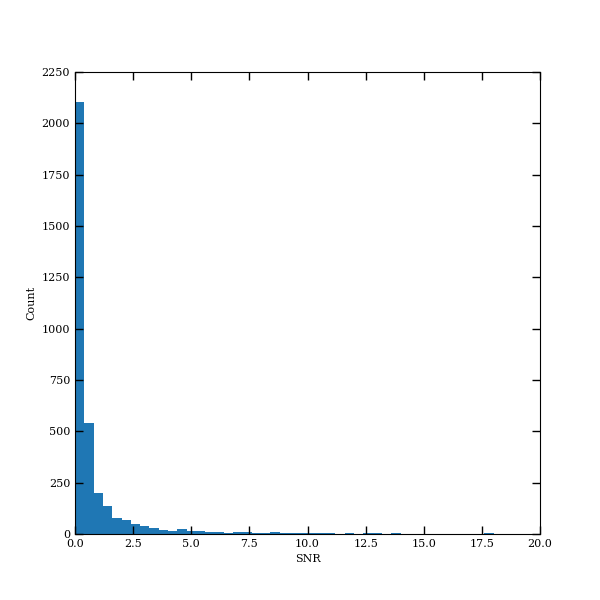

Text(0, 0.5, 'Count')

In [15]:
plt.figure()
plt.hist(snrs, bins=50, range=(0,20))
plt.xlabel('SNR')
plt.ylabel('Count')

<IPython.core.display.Javascript object>


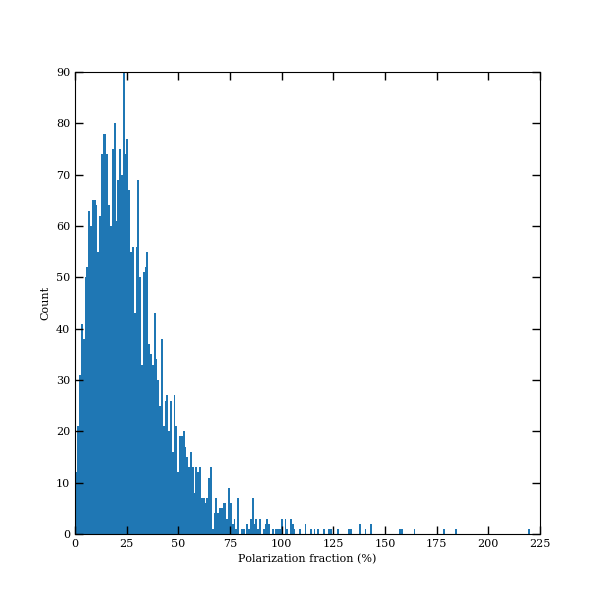

Text(0, 0.5, 'Count')

In [16]:
plt.figure()
plt.hist(fracs, bins=250)
plt.xlabel('Polarization fraction (%)')
plt.ylabel('Count')

In [68]:
len(fracs[snrs>1])

720

<IPython.core.display.Javascript object>


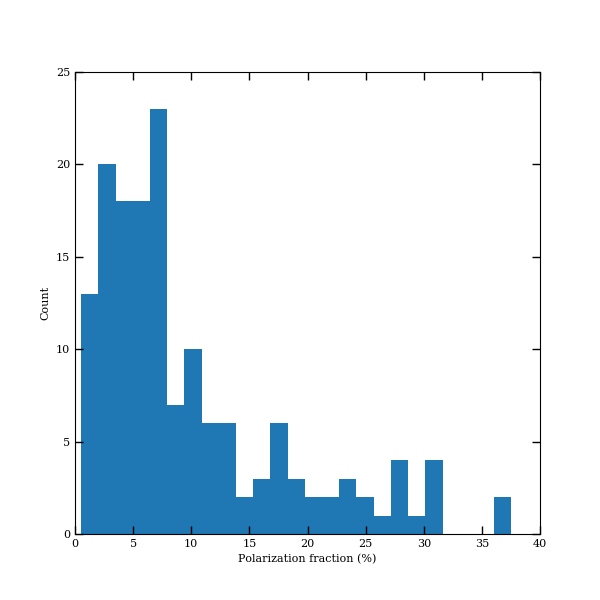

Text(0, 0.5, 'Count')

In [18]:
plt.figure()
plt.hist(fracs[snrs>5], bins=25)
plt.xlabel('Polarization fraction (%)')
plt.ylabel('Count')

In [21]:
def makeplots(i):
    idata = SpectralCube.read(mydoc[i]["i_file"], mode='denywrite')
    qdata = SpectralCube.read(mydoc[i]["q_file"], mode='denywrite')
    udata = SpectralCube.read(mydoc[i]["u_file"], mode='denywrite')
    pdata = (qdata**2 + udata**2)**0.5
    freq = idata.spectral_axis
    im_av = idata.sum(axis=0)
    im_av.quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('SUM(I) - STOKES I')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    idata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('STOKES I')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    qdata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('STOKES Q')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    udata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('STOKES U')
    fig.set_figheight(4)
    fig.set_figwidth(4)

    pdata[0].quicklook()
    fig = plt.gcf()
    ax = plt.gca()
    fig.suptitle('PI')
    fig.set_figheight(4)
    fig.set_figwidth(4)
    ind = np.unravel_index(np.argmax(im_av, axis=None), im_av.shape)
    print(ind)
    plt.plot(ind[1],ind[0], 'r+')
    
    plt.figure()
    plt.plot(freq/1e6, idata[:,ind[0], ind[1]], 'k', label='I')
    plt.plot(freq/1e6, qdata[:,ind[0], ind[1]], 'tab:red', label='Q')
    plt.plot(freq/1e6, udata[:,ind[0], ind[1]], 'tab:blue', label='U')
    plt.legend()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('Flux (Jy/beam)')
    #FDFcube, phiArr_radm2, lam0Sq_m2, lambdaSqArr_m2 = run_rmsynth(qdata,
    #                                                               udata,
    #                                                               freq,
    #                                                               phiMax_radm2=1000,
    #                                                               not_rmsf=True,
    #                                                               verbose=True,
    #                                                              )
    #plt.figure()
    #plt.imshow(np.abs(FDFcube).sum(axis=0), origin='lower', cmap='magma')
    #plt.contour(im_av, origin='lower', colors='w', alpha=0.1)
    #plt.title('SUM(ABS(FDF)) -- PI')
    #frac = pdata/idata*100
    #print(f'Polarzation fraction is {frac[0,ind[0], ind[1]]:.2f}% at {freq[0]/1e6:.1f}GHz')
#
    #peak_pi_idx = np.argmax(FDFcube, axis=0)
    #plt.figure()
    #plt.title('Peak PI')
    #plt.imshow(phiArr_radm2[peak_pi], cmap='RdBu_r', origin='lower')
    #plt.colorbar()
    #plt.contour(np.abs(FDFcube).sum(axis=0), origin='lower', colors='k', alpha=0.1)

<IPython.core.display.Javascript object>


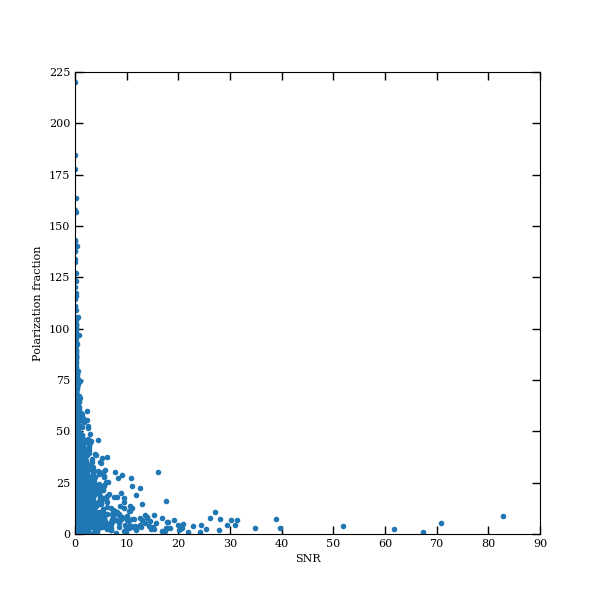

Text(0, 0.5, 'Polarization fraction')

In [19]:
plt.figure()
plt.plot(snrs, fracs, '.')
#plt.plot([1, 90], [5,5], 'r')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('SNR')
plt.ylabel('Polarization fraction')

In [26]:
np.sqrt(len(snrs[snrs>5]))

13.0

In [27]:
enumerate(np.where(snrs>5)[0])

<IPython.core.display.Javascript object>


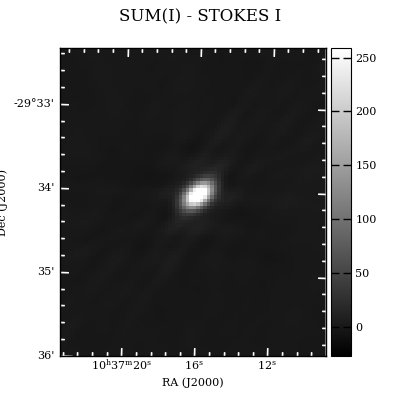

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


INFO: Auto-setting vmin to -2.726e+01 [aplpy.core]
INFO: Auto-setting vmax to  2.590e+02 [aplpy.core]


<IPython.core.display.Javascript object>


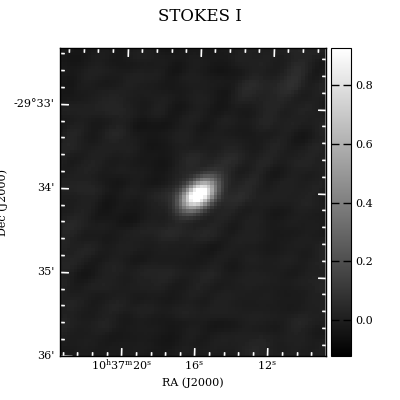

INFO: Auto-setting vmin to -1.208e-01 [aplpy.core]
INFO: Auto-setting vmax to  9.243e-01 [aplpy.core]


<IPython.core.display.Javascript object>


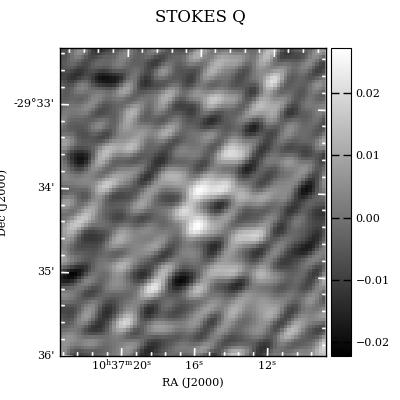

INFO: Auto-setting vmin to -2.227e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.725e-02 [aplpy.core]


<IPython.core.display.Javascript object>


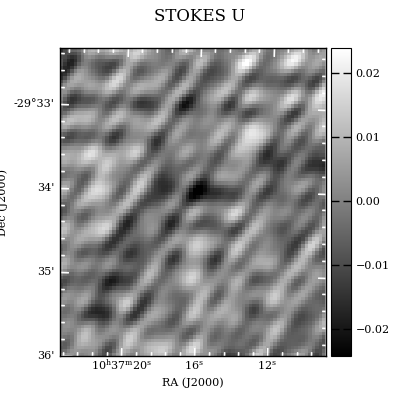

INFO: Auto-setting vmin to -2.419e-02 [aplpy.core]
INFO: Auto-setting vmax to  2.385e-02 [aplpy.core]


<IPython.core.display.Javascript object>


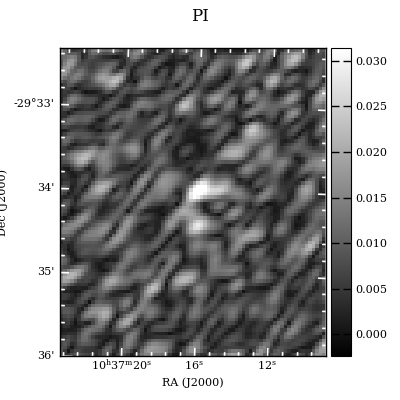

INFO: Auto-setting vmin to -2.356e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.137e-02 [aplpy.core]
(46, 39)


<IPython.core.display.Javascript object>


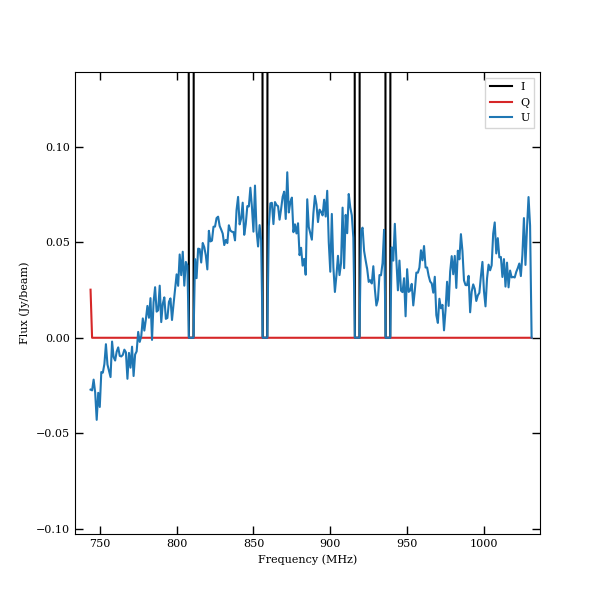

In [22]:
makeplots(0)

In [26]:
i = 0
idata = SpectralCube.read(mydoc[i]["i_file"], mode='denywrite')
qdata = SpectralCube.read(mydoc[i]["q_file"], mode='denywrite')
udata = SpectralCube.read(mydoc[i]["u_file"], mode='denywrite')
pdata = (qdata**2 + udata**2)**0.5

In [23]:
idata.beam

NameError: name 'idata' is not defined

In [32]:
import radio_beam
from astropy import units as u
from astropy.convolution import Gaussian1DKernel

In [20]:
freq = idata.spectral_axis
im_av = idata.sum(axis=0)
im_av.quicklook()
fig = plt.gcf()
ax = plt.gca()
fig.suptitle('SUM(I) - STOKES I')
fig.set_figheight(4)
fig.set_figwidth(4)

idata[0].quicklook()
fig = plt.gcf()
ax = plt.gca()
fig.suptitle('STOKES I')
fig.set_figheight(4)
fig.set_figwidth(4)

qdata[0].quicklook()
fig = plt.gcf()
ax = plt.gca()
fig.suptitle('STOKES Q')
fig.set_figheight(4)
fig.set_figwidth(4)

udata[0].quicklook()
fig = plt.gcf()
ax = plt.gca()
fig.suptitle('STOKES U')
fig.set_figheight(4)
fig.set_figwidth(4)

pdata[0].quicklook()
fig = plt.gcf()
ax = plt.gca()
fig.suptitle('PI')
fig.set_figheight(4)
fig.set_figwidth(4)

NameError: name 'idata' is not defined

<IPython.core.display.Javascript object>


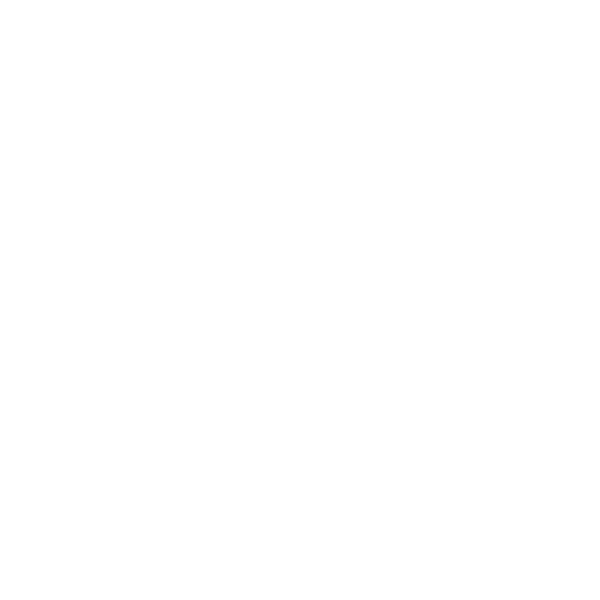

(46, 39)


<IPython.core.display.Javascript object>


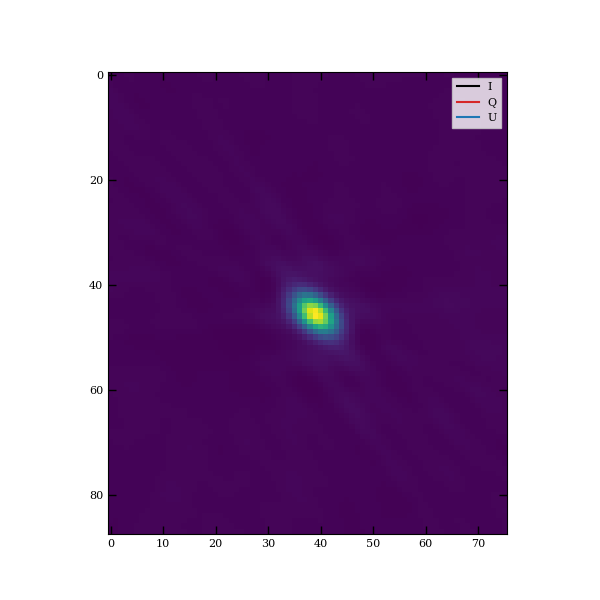

In [49]:
freq = idata.spectral_axis
im_av = idata.sum(axis=0)
peak = np.argmax(im_av)
plt.figure()
plt.imshow(im_av, origin='lower')
plt.title('SUM(I) - STOKES I')
ind = np.unravel_index(np.argmax(im_av, axis=None), im_av.shape)
print(ind)
plt.plot(ind[1],ind[0], 'r+')
with fits.open(mydoc[i]["q_file"], memmap=True, mode='denywrite') as qlist:
    with fits.open(mydoc[i]["u_file"], memmap=True, mode='denywrite') as ulist:
        qdu = qlist[0]
        qdata = qdu.data
        udu = ulist[0]
        udata = udu.data
pdata = np.sqrt(udata**2+qdata**2)
plt.figure()
plt.plot(freq/1e6, idata[:,ind[0], ind[1]], 'k', label='I')
plt.plot(freq/1e6, qdata[:,ind[0], ind[1]], 'tab:red', label='Q')
plt.plot(freq/1e6, udata[:,ind[0], ind[1]], 'tab:blue', label='U')
plt.legend()
#FDFcube, phiArr_radm2, lam0Sq_m2, lambdaSqArr_m2 = run_rmsynth(qdata,
#                                                               udata,
#                                                               freq,
#                                                               phiMax_radm2=1000,
#                                                               not_rmsf=True,
#                                                               verbose=True,
#                                                              )
#plt.figure()
#plt.imshow(np.abs(FDFcube).sum(axis=0), origin='lower', cmap='magma')
#plt.contour(im_av, origin='lower', colors='w', alpha=0.1)
#plt.title('SUM(ABS(FDF)) -- PI')
#frac = pdata/idata*100
#p#rint(f'Polarzation fraction is {frac[0,ind[0], ind[1]]:.2f}% at {freq[0]/1e6:.1f}GHz')
#
#peak_pi_idx = np.argmax(FDFcube, axis=0)
#plt.figure()
#plt.title('Peak PI')
#plt.imshow(phiArr_radm2[peak_pi], cmap='RdBu_r', origin='lower')
#plt.colorbar()
#plt.contour(np.abs(FDFcube).sum(axis=0), origin='lower', colors='k', alpha=0.1)

<IPython.core.display.Javascript object>


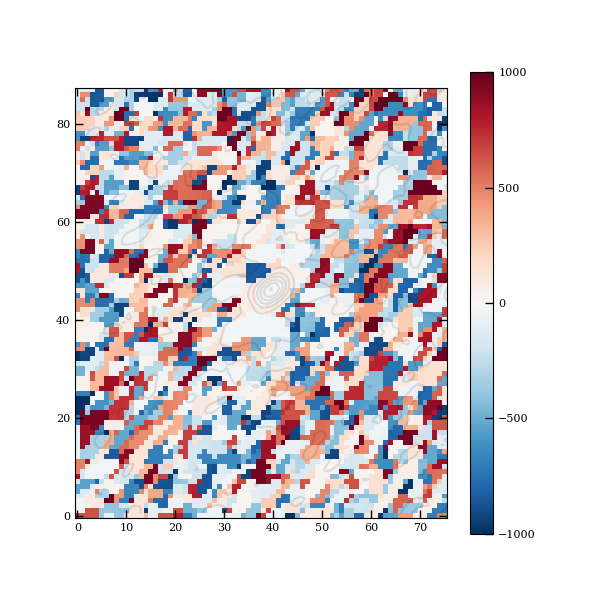